This example is inspired in the seminal paper: Kinetic Phase Transitions in
an Irreversible Surface-Reaction Model by Robert M. Ziff, Erdagon Gulari,
and Yoav Barshad in 1986
[Phys. Rev. Lett. 56, (1986) 2553](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.56.2553>).
The authors proposed a simple model for catalytic reactions of carbon monoxide
oxidation to carbon dioxide on a surface. This model is now known as the
Ziff-Gulari-Barshad (ZGB) model after their names.  While the model leaves
out many important steps of the real system, it exhibits interesting
steady-state off-equilibrium behavior and two types of phase transitions,
which actually occur in real systems. Please refer to the original paper
for more details. In this example, we will analyze the effect of changing
the composition of the gas phase, namely partial pressures for $O_2$ and $CO$,
in the $CO_2$ Turnover frequency (TOF) in the ZGB model.

The first step is to import all packages we need:

In [1]:
import multiprocessing
import numpy
import scm.plams
import scm.pyzacros as pz

First must define the system. So, we have to specify species, lattice, cluster
expansion, and mechanisms. As we said above, we will use the ZGB model, which
consists on:

**1. Three gas species:** $CO$, $O_2$, and $CO_2$. Notice that the ``gas_energy``
by default is zero unless otherwise stated. That's the case for $CO$ and $O2$,
which are used as energy references.

In [2]:
CO_gas = pz.Species("CO")
O2_gas = pz.Species("O2")
CO2_gas = pz.Species("CO2", gas_energy=-2.337)

**2. Three surface species:** $*$, $CO^*$, $O^*$. The species $*$ represents the
empty adsorption site. All of them have denticity equal to 1.

In [3]:
s0 = pz.Species("*", 1)
CO_ads = pz.Species("CO*", 1)
O_ads = pz.Species("O*", 1)

**3. A rectangular lattice with a single site type**.

In [4]:
lattice = pz.Lattice(lattice_type=pz.Lattice.RECTANGULAR, lattice_constant=1.0, repeat_cell=[50, 50])

**4. Two clusters in the cluster-expansion Hamiltonian:** $CO^*$-bs and $O^*$-bs.
They are attached to a single binding site. No lateral interactions are considered.

In [5]:
CO_point = pz.Cluster(species=[CO_ads], energy=-1.3)
O_point = pz.Cluster(species=[O_ads], energy=-2.3)

cluster_expansion = [CO_point, O_point]

**5. Three irreversible events**: adsorption of $CO$, dissociative adsorption
of $O_2$, and $CO$ oxidation.

In [6]:
# CO_adsorption:
CO_adsorption = pz.ElementaryReaction(
    initial=[s0, CO_gas], final=[CO_ads], reversible=False, pre_expon=10.0, activation_energy=0.0
)

# O2_adsorption:
O2_adsorption = pz.ElementaryReaction(
    initial=[s0, s0, O2_gas],
    final=[O_ads, O_ads],
    neighboring=[(0, 1)],
    reversible=False,
    pre_expon=2.5,
    activation_energy=0.0,
)

# CO_oxidation:
CO_oxidation = pz.ElementaryReaction(
    initial=[CO_ads, O_ads],
    final=[s0, s0, CO2_gas],
    neighboring=[(0, 1)],
    reversible=False,
    pre_expon=1.0e20,
    activation_energy=0.0,
)

mechanism = [CO_adsorption, O2_adsorption, CO_oxidation]

Now, we initialize the **pyZacros** environment.

In [7]:
scm.pyzacros.init()

PLAMS working folder: /home/aguirre/Develop/pyzacros/examples/ZiffGulariBarshad/plams_workdir


This calculation is relatively fast. On a typical laptop, it should take
around 1 min to complete. However, to illustrate how to run several in
parallel Zacros calculations, we'll use the ``plams.JobRunner`` class,
which easily allows us to run as many parallel instances as we request.
In this case, we choose to use the maximum number of simultaneous processes
(``maxjobs``) equal to the number of processors in the machine. Additionally,
by setting ``nproc =  1`` we establish that only one processor will be used
for each zacros instance. 

In [8]:
maxjobs = multiprocessing.cpu_count()
scm.plams.config.default_jobrunner = scm.plams.JobRunner(parallel=True, maxjobs=maxjobs)
scm.plams.config.job.runscript.nproc = 1
print("Running up to {} jobs in parallel simultaneously".format(maxjobs))

Running up to 8 jobs in parallel simultaneously


Now we have to set up the calculation using a ``Settings`` object. Firstly,
we set a reactants gas phase composition of 45% $CO$ and 55% $O_2$. Notice
that we assumed that the gas phase is composed only of $CO$ and $O_2$; thus,
$x_\text{CO} +x_{\text{O}_2} =1$. Keep in mind that these values are actually
not affecting the calculation because, later on, these are the ones we will
modify systematically. Then, we set the physical parameters as temperature
(500 K) and pressure (1 bar). Finally, we set the maximum time for the
simulation to 10 s (``max_time``), and we save snapshots of the lattice state
every 0.5 s (``snapshots``) and the number of species every 0.1 s
(``species_numbers``). The last line sets the random seed to make the
calculations reproducible.

In [9]:
sett = pz.Settings()
sett.molar_fraction.CO = 0.45
sett.molar_fraction.O2 = 0.55
sett.temperature = 500.0
sett.pressure = 1.0
sett.max_time = 10.0
sett.snapshots = ("time", 0.5)
sett.species_numbers = ("time", 0.1)
sett.random_seed = 953129

The calculation parameters setup is ready. Therefore, we can proceed to run
the calculations. In this instance, we are interested in exploring the
production of $CO_2$ by ranging the $CO$ molar fraction ``x_CO`` from 0.02
to 0.8 in steps of 0.01. Remember that $O_2$ molar fraction is set to satisfy
$x_\text{CO}+x_{\text{O}_2}=1$. The loop creates one ``ZacrosJob`` for each
value of ``x_CO`` (condition) using the settings and system's properties
defined above and executing it by invoking the function ``run()``. Notice
that results are stored in the vector ``results`` for further analysis once
they are finished. In the output, observe that **pyZacros** creates a new
folder for each condition, following the sequence ``plamsjob.002``,
``plamsjob.003``, ``plamsjob.004``, and so on for ``x_CO=0.20, 0.21, 0.22, ...``
respectively. The second loop calls the method ``job.ok()`` of every job to
ensure that every calculation was completed successfully and wait for all
parallel processes to complete before proceeding to access the results.

In [10]:
x_CO = numpy.arange(0.2, 0.8, 0.01)

results = []
for x in x_CO:
    sett.molar_fraction.CO = x
    sett.molar_fraction.O2 = 1.0 - x

    job = pz.ZacrosJob(settings=sett, lattice=lattice, mechanism=mechanism, cluster_expansion=cluster_expansion)

    results.append(job.run())

for i, x in enumerate(x_CO):
    if not results[i].job.ok():
        print("Something went wrong with condition xCO={}!".format(x))

[02.02|22:23:20] JOB plamsjob STARTED
[02.02|22:23:20] JOB plamsjob STARTED
[02.02|22:23:20] Renaming job plamsjob to plamsjob.002
[02.02|22:23:20] JOB plamsjob STARTED
[02.02|22:23:20] Renaming job plamsjob to plamsjob.003
[02.02|22:23:20] JOB plamsjob STARTED
[02.02|22:23:20] Renaming job plamsjob to plamsjob.004
[02.02|22:23:20] JOB plamsjob STARTED
[02.02|22:23:20] Renaming job plamsjob to plamsjob.005
[02.02|22:23:20] JOB plamsjob STARTED
[02.02|22:23:20] JOB plamsjob RUNNING
[02.02|22:23:20] Renaming job plamsjob to plamsjob.006
[02.02|22:23:20] JOB plamsjob STARTED
[02.02|22:23:20] JOB plamsjob.002 RUNNING
[02.02|22:23:20] Renaming job plamsjob to plamsjob.007
[02.02|22:23:20] JOB plamsjob STARTED
[02.02|22:23:20] JOB plamsjob.003 RUNNING
[02.02|22:23:20] JOB plamsjob.004 RUNNING
[02.02|22:23:20] Renaming job plamsjob to plamsjob.008
[02.02|22:23:20] JOB plamsjob STARTED
[02.02|22:23:20] JOB plamsjob.005 RUNNING
[02.02|22:23:20] Renaming job plamsjob to plamsjob.009
[02.02|22:23

If the script worked successfully, you should have seen several
``SUCCESSFUL`` messages at the output's end.

Now we need to extract the results we want, in this case, the
average coverage and the turnover frequency of $CO_2$, and store
them conveniently, as in arrays. We use the ``turnover frequency``
method for the latter, and average coverage for the former, specifying
that we want to use the last five lattice states (``last=5``):

In [11]:
ac_O = []
ac_CO = []
TOF_CO2 = []

for i, x in enumerate(x_CO):
    ac = results[i].average_coverage(last=5)
    TOFs, _, _, _ = results[i].turnover_frequency()

    ac_O.append(ac["O*"])
    ac_CO.append(ac["CO*"])
    TOF_CO2.append(TOFs["CO2"])

Finally, we just nicely print the results in a table.

In [12]:
print("----------------------------------------------")
print("%4s" % "cond", "%8s" % "x_CO", "%10s" % "ac_O", "%10s" % "ac_CO", "%10s" % "TOF_CO2")
print("----------------------------------------------")

for i, x in enumerate(x_CO):
    print("%4d" % i, "%8.2f" % x_CO[i], "%10.6f" % ac_O[i], "%10.6f" % ac_CO[i], "%10.6f" % TOF_CO2[i])

----------------------------------------------
cond     x_CO       ac_O      ac_CO    TOF_CO2
----------------------------------------------
   0     0.20   0.998000   0.000000   0.049895
   1     0.21   1.000000   0.000000   0.046695
   2     0.22   1.000000   0.000000   0.051747
   3     0.23   0.998880   0.000000   0.053747
   4     0.24   0.997600   0.000000   0.061937
   5     0.25   0.996560   0.000000   0.087368
   6     0.26   0.998960   0.000000   0.073600
   7     0.27   0.998160   0.000000   0.085537
   8     0.28   0.997680   0.000000   0.098905
   9     0.29   0.994560   0.000000   0.111011
  10     0.30   0.995840   0.000000   0.123811
  11     0.31   0.996320   0.000000   0.134463
  12     0.32   0.991760   0.000000   0.163811
  13     0.33   0.991680   0.000000   0.165958
  14     0.34   0.989360   0.000000   0.224589
  15     0.35   0.981680   0.000000   0.273811
  16     0.36   0.962960   0.000240   0.319789
  17     0.37   0.963440   0.000160   0.352800
  18     0.38

The above results are the final aim of the calculation. However, we
can take advantage of python libraries to visualize them. Here, we
use matplotlib. Please check the matplotlib documentation for more
details at [matplotlib](https://matplotlib.org/). The following lines
of code allow visualizing the effect of changing the $CO$ molar
fraction on the average coverage of $O*$ and $CO*$ and the production
rate of $CO_2$:

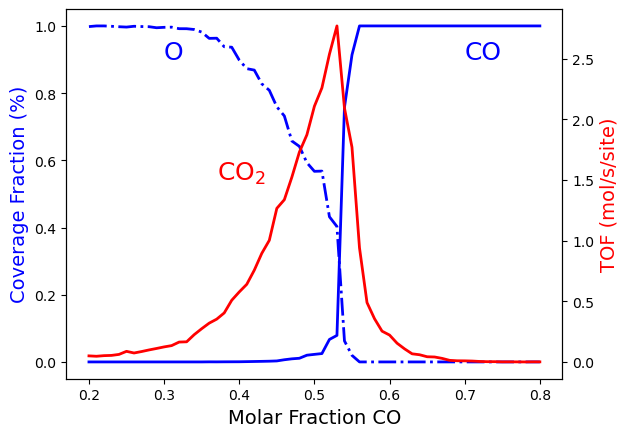

In [13]:
import matplotlib.pyplot as plt

fig = plt.figure()

ax = plt.axes()
ax.set_xlabel("Molar Fraction CO", fontsize=14)
ax.set_ylabel("Coverage Fraction (%)", color="blue", fontsize=14)
ax.plot(x_CO, ac_O, color="blue", linestyle="-.", lw=2, zorder=1)
ax.plot(x_CO, ac_CO, color="blue", linestyle="-", lw=2, zorder=2)
plt.text(0.3, 0.9, "O", fontsize=18, color="blue")
plt.text(0.7, 0.9, "CO", fontsize=18, color="blue")

ax2 = ax.twinx()
ax2.set_ylabel("TOF (mol/s/site)", color="red", fontsize=14)
ax2.plot(x_CO, TOF_CO2, color="red", lw=2, zorder=5)
plt.text(0.37, 1.5, "CO$_2$", fontsize=18, color="red")

plt.show()

This model assumes that gas-phase molecules of $CO$ and $O_2$ are
adsorbed immediately on empty sites, and when the $0*$ and $CO*$ occupy
adjacent sites, they react immediately. This model is intrinsically
irreversible because the molecules are sticky to their original sites
and remain stationary until they are removed by a reaction. This leads
to the figure above having three regions:

1. Oxygen poisoned state, $x_\text{CO}<0.32$.
2. Reactive state $0.32<x_\text{CO}<0.55$.
3. CO poisoned state $x_\text{CO}>0.55$.

The first transition at $x_\text{CO}=0.32$ is continuous, and therefore
it is of the second order. The second transition at $x_\text{CO}=0.55$
occurs abruptly, implying that this is of a first-order transition.
As you increase the simulation time, the transition becomes more abrupt.
We will discuss this effect in the next tutorial
**Ziff-Gulari-Barshad model: Steady State Conditions**.

**pyZacros** also offers some predefined plot functions that use matplotlib
as well. For example, it is possible to see a typical reactive state
configuration $x_\text{CO}=0.54$ and one in the process of being poisoned
by $CO$ ($x_\text{CO}=0.55$). Just get the last lattice state with the
``last_lattice_state()`` function and visualize it with ``plot()``. See
the code and figures below.

The state at $x_\text{CO}=0.54$ is a prototypical steady-state,

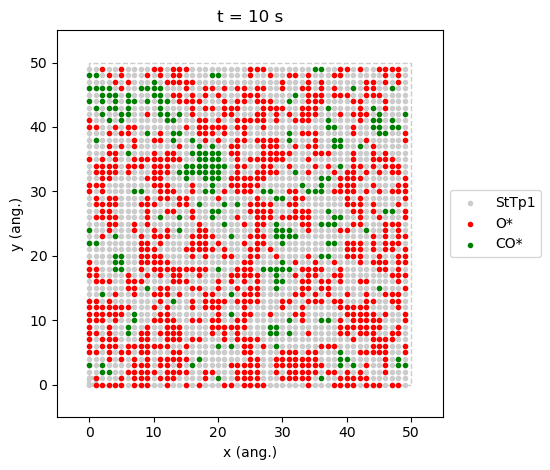

In [14]:
results[33].last_lattice_state().plot()

contrary to the one at $x_\text{CO}=0.55$, is a good example
where we can see the two phases coexisting.

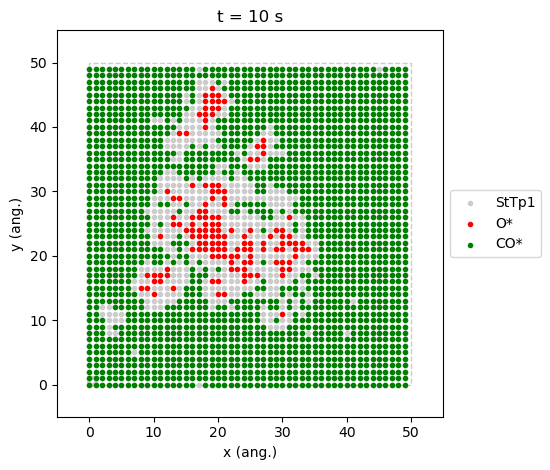

In [15]:
results[34].last_lattice_state().plot()

In the previous paragraph, we introduced the concept of steady-state.
However, let's define it slightly more formally. For our study system,
the steady-state for a given composition is characterized when the
derivative of the $CO_2$ production (TOF) with respect to time is zero
and remains so:

$$
\frac{d}{dt}TOF_{\text{CO}_2} = 0, \,\,\text{for all present and future}\,\, t
$$

**pyZacros** also offers the function ``plot_molecule_numbers()`` to
visualize the molecule numbers and its first derivative as a function
of time. See code and figures below:

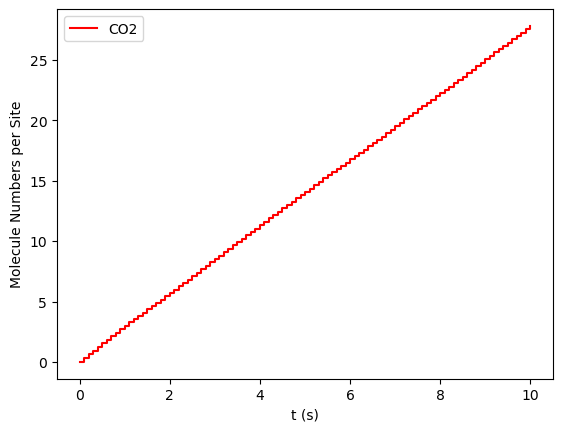

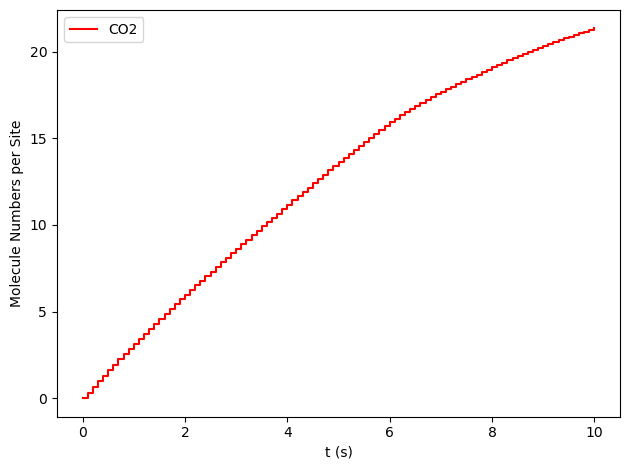

In [16]:
results[33].plot_molecule_numbers(["CO2"], normalize_per_site=True)
results[34].plot_molecule_numbers(["CO2"], normalize_per_site=True)

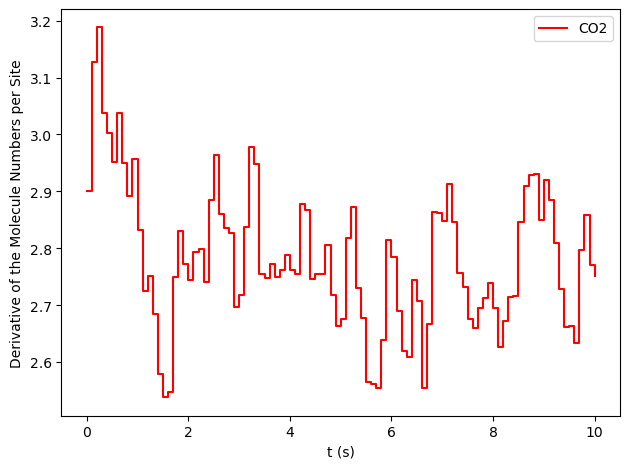

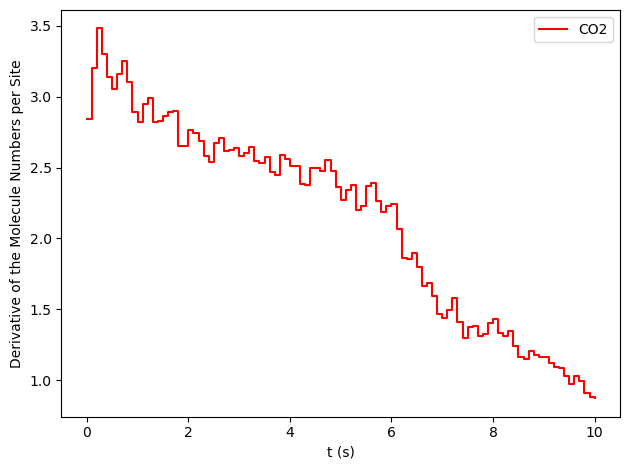

In [17]:
results[33].plot_molecule_numbers(["CO2"], normalize_per_site=True, derivative=True)
results[34].plot_molecule_numbers(["CO2"], normalize_per_site=True, derivative=True)

From the figures above, it is clear that we have reached a steady-state for
$x_\text{CO}=0.54$. Notice that the first derivative is approximately constant
at 2.7 mol/s/site within a tolerance of 5 mol/s/site. Contrary, this is not
the case of $x_\text{CO}=0.55$, where the first derivative continuously decreases.

Now, we can close the pyZacros environment:

In [18]:
scm.pyzacros.finish()

[02.02|22:24:09] PLAMS run finished. Goodbye
